In [1]:
## Prioritize rapidly scalable methane reductions in efforts to mitigate climate change
## Dunn J.B., Salas S.D., Chen Q. and Allen D.T. Clean Technologies and Environmental Policy. 2023
## @author: Santiago D. Salas, Ph.D. - Postdoctoral Scholar - Northwestern University.
## Advisor: Prof. Jennifer B. Dunn

In [2]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [3]:
tau_ch4 = 11.8 # years, AR6
phi_ch4 = 2.11 * 10**(-13) / 1E-9 # W/(m^2*Tg)
phi_co2 = 1.76 * 10**(-15) / 1E-9 # W/(m^2*Tg)
lambda_cc = 0.852 ## K m^2 / (yr*W) ## Gasser et al. 2017 version OSCAR v2.2

def r_Q_co2_cc(t):
    # carbon dioxide response, appendix C1 in Gasser
    return 0.2366 + 0.2673 * np.exp(-t/4.272) + 0.2712 * np.exp(-t/33.10) + 0.2249 * np.exp(-t/302.4) ## OSCAR v2.2 with cc feedback

def r_Q_ch4(t):
    # methane response, appendix D2 in Gasser
    return np.exp(-t/tau_ch4)

def rT(t):
    # climate response, appendix C2 in Gasser
    return 0.572/3.50 * np.exp(-t/3.50) + 0.428/166. * np.exp(-t/166.) # Gasser et al. 2017 version OSCAR v2.2
    # return 0.587/4.1 * np.exp(-t/4.1) + 0.413/249 * np.exp(-t/249) # Geoffroy et al. 2013 version

def rF(t):
    # leaving out the delta function part
    return 0.6368/2.376 * np.exp(-t/2.376) + 0.3322/30.14 * np.exp(-t/30.14) + 0.031/490.1 * np.exp(-t/490.1)

time_H =        100 ## years
time_interval = 0.25 ## months

H = np.linspace(0,time_H,int(12/time_interval*time_H+1))

AGWP_co2 = np.zeros(np.shape(H))
AGWP_ch4 = np.zeros(np.shape(H))
AGTP_co2 = np.zeros(np.shape(H))
AGTP_ch4 = np.zeros(np.shape(H))

In [4]:
r_Q_co2_calc = r_Q_co2_cc(H)
r_Q_ch4_calc = r_Q_ch4(H)

### Calculate AGWP for CO2 and CH4
i = 0
for h in H:
    AGWP_co2[i] = phi_co2 * sum(r_Q_co2_calc[0:i+1]*time_interval/12.)    ### for CO2
    AGWP_ch4[i] = phi_ch4 * sum(r_Q_ch4_calc[0:i+1]*time_interval/12.)    ### for CH4
    i += 1
GWP_ch4 = AGWP_ch4 / AGWP_co2

### To calculate AGTP for CO2 and CH4
i = 0
for h in H:    
    temp = 0.0    ### for CO2
    for t in range(0,i+1):
        ti = t*time_interval/12
        temp += r_Q_co2_cc(ti) * rT(h-ti) * time_interval/12. 
    AGTP_co2[i] = phi_co2 * lambda_cc * temp    
    temp = 0.0    ### for CH4
    for t in range(0,i+1):
        ti = t*time_interval/12
        temp += r_Q_ch4(ti) * rT(h-ti) * time_interval/12.
    AGTP_ch4[i] = phi_ch4 * lambda_cc * temp
    i += 1
GTP_ch4 = AGTP_ch4 / AGTP_co2

### Dynamic Metric Calculator

In [5]:
def Em_calc(H,E_ch4,metric):
    ne = len(H)
    E = np.zeros((ne,ne))
    met = np.zeros((ne,ne))    
    for i in range(0,ne):
        for j in range(i,ne):
            E[i,j] = E_ch4[i]    
    for i in range(0,ne):
        for j in range(i,ne):
            met[i,j] = metric[j-i]    
    Dyn_m = E*met
    Dyn_m_tot = sum(Dyn_m)    
    return Dyn_m_tot

### Methane emission scenarios

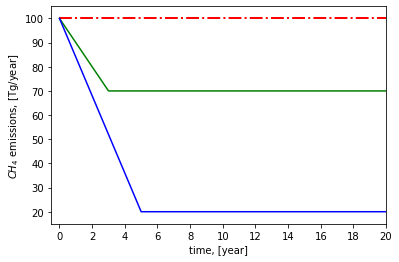

In [6]:
################# BAU - constant emissions
em_ch4 = 100.
E_ch4_i = np.ones(len(H))*em_ch4/(12./time_interval) ## ton CH4/time int

################# Y0L3 - Linear decay in 30% at year 0 over 3 years
red = 0.3
red_year = 0
E_ch4_i_lin = np.ones(len(H))*em_ch4/(12./time_interval) ## ton CH4/time int
red_year_end = 3
n_init = int(red_year*12/time_interval)
n_end = int(red_year_end*12/time_interval)

m = (em_ch4)/(12./time_interval)*((1.-red)-1)/(red_year_end-red_year)

def y(x):
    return m*x + em_ch4/(12./time_interval)

for i in range(n_init,n_end):
    E_ch4_i_lin[i] = y((i-n_init)/(12./time_interval)) # linear decay

E_ch4_i_lin[int(red_year_end*12/time_interval):] = (em_ch4*(1.-red))/(12./time_interval) #30% reduction

################# Y0L5 - Linear decay in 80% at year 0 over 5 years
red = 0.8
E_ch4_i_lin1 = np.ones(len(H))*em_ch4/(12./time_interval) ## ton CH4/time int
red_year_end = 5

n_init = int(red_year*12/time_interval)
n_end = int(red_year_end*12/time_interval)

m = (em_ch4)/(12./time_interval)*((1.-red)-1)/(red_year_end-red_year)

def y(x):
    return m*x + em_ch4/(12./time_interval)

for i in range(n_init,n_end):
    E_ch4_i_lin1[i] = y((i-n_init)/(12./time_interval)) # linear decay

E_ch4_i_lin1[int(red_year_end*12/time_interval):] = (em_ch4*(1.-red))/(12./time_interval) #30% reduction

E_ch4_i = np.stack((E_ch4_i,E_ch4_i_lin,E_ch4_i_lin1))

### Methane emissions ###
em_n = len(E_ch4_i)
em_color = ['r','g','b']
em_ls = ['-.','-','-']
em_label = ['Base case', 'Y0L3', 'Y0L5']

wdt = [2,1.5,1.5]
plt_y_label = '$CH_{4}$ emissions, [Tg/year]'

for i in range(0,em_n):
    plt.plot(H, E_ch4_i[i]*(12./time_interval),
             color=em_color[i],linestyle=em_ls[i],
             label=em_label[i],linewidth=wdt[i])
plt.xlabel('time, [year]')
plt.xlim([-0.5, 20])
plt.ylim([15, 105])
plt.ylabel(plt_y_label)
plt.xticks(np.arange(0, 21, 2.0))
plt.savefig('Scenarios1.png', dpi=800)
plt.show()

RF_gwp      =   np.zeros(np.shape(E_ch4_i))
T_gtp       =   np.zeros(np.shape(E_ch4_i))

stp_ch = [1,3,5]
ln_dc = [2,4,6]

for i in range(0,em_n):
    #### Radiative Forcing calculation
    RF_gwp[i] = Em_calc(H, E_ch4_i[i], AGWP_ch4)    
    #### Temperature change + int
    T_gtp[i] = Em_calc(H, E_ch4_i[i]*1E3, AGTP_ch4)    

### Carbon dioxide emissions scenarios

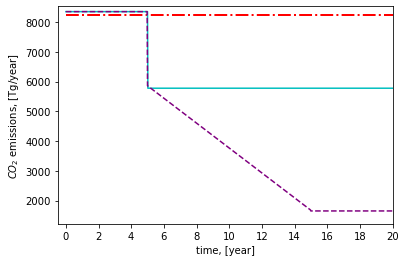

In [7]:
GWP_20 = 82.5
red = 0.3
################# Y5SI - Step change in 30% after 5 years + infrastructure emissions CCS average
red_year3 = 5
E_co2_i_ccs_5 = np.ones(len(H))*em_ch4*(1+(6.0/100/red_year3))/(12./time_interval)*GWP_20 ## ton CO2/time int
E_co2_i_ccs_5[int(red_year3*12/time_interval+1):] = (em_ch4*(1.-red))/(12./time_interval)*GWP_20 #30% reduction

################# Y5SLI - Step change in 80% after 5 years + infrastructure emissions CCS average, then linear for 10 years
red = 0.8
red_year4 = 5
em_ch4_2 = 70
E_co2_i_15 = np.ones(len(H))*em_ch4*(1+(6.0/100/red_year4))/(12./time_interval)*GWP_20 ## ton CO2/time int
red_year = 5
red_year_end = 15
n_init = int(red_year*12/time_interval)
n_end = int(red_year_end*12/time_interval)

m = (em_ch4_2)/(12./time_interval)*((1.-(1-20/70))-1)/(red_year_end-red_year)

def y(x):
    return (m*x + em_ch4_2/(12./time_interval))

for i in range(n_init,n_end):
    E_co2_i_15[i] = y((i-n_init)/(12./time_interval))*(1+(14.3/100/(red_year_end-red_year)))*GWP_20 # linear decay

E_co2_i_15[int(red_year_end*12/time_interval):] = (em_ch4*(1.-red))/(12./time_interval)*GWP_20 #30% reduction

E_co2e_i = E_ch4_i*GWP_20
E_co2_i_ccs = np.stack((E_co2e_i[0],E_co2_i_ccs_5,E_co2_i_15))

em_co2 = len(E_co2_i_ccs)
plt_y_label = '$CO_{2}$ emissions, [Tg/year]'
em_color2 = ['r','c','purple']
em_ls = ['-.','-','--']
em_label = ['Base case','Y5SI','Y5SLI']
wdt = [2,1.5,1.5,1.5,1.5,2,2]

for i in range(0,em_co2):
    plt.plot(H, E_co2_i_ccs[i]*(12./time_interval),
             color=em_color2[i],linestyle=em_ls[i],
             label=em_label[i],linewidth=wdt[i])
plt.xlabel('time, [year]')
plt.xlim([-0.5, 20])
plt.ylim([15*81.2, 105*81.2])
plt.ylabel(plt_y_label)
plt.xticks(np.arange(0, 21, 2.0))
plt.savefig('Scenarios2.png', dpi=800)
plt.show()

RF_co2_ccs      =   np.zeros(np.shape(E_co2_i_ccs))
T_co2_ccs       =   np.zeros(np.shape(E_co2_i_ccs))

for i in range(0,em_co2):
    RF_co2_ccs[i] = Em_calc(H,E_co2_i_ccs[i],AGWP_co2) ### CCS #### Radiative Forcing calculation   
    T_co2_ccs[i] = Em_calc(H,E_co2_i_ccs[i]*1E3, AGTP_co2) #### Temperature change + int

### Global surface temperature change avoided

In [8]:
T_av_ch4 = T_gtp[0]-T_gtp[1:]
T_av_co2 = T_co2_ccs[0]-T_co2_ccs[1:]

### Scenario comparison CH4 v. CO2

ch4_label = ['Y0L3 (CH$_{4}$)','Y0L5 (CH$_{4}$)']
ch4_color = ['g','b']

co2_label = ['Y5SI (CO$_{2}$)','Y5SLI (CO$_{2}$)']
co2_color = ['c','purple']
co2_line = ['--','--']
#####################
### Plateau check ###
#####################

slope_T_av_ch4 = np.zeros(np.shape(T_av_ch4))
sl_chng = np.zeros(np.shape(T_av_ch4))
x_den = H[1]-H[0]
slp_n = len(H)

for i in range(0,slp_n):
    if i == 0:
        slope_T_av_ch4[0][i] = 0.
    else:
        slope_T_av_ch4[0][i] = (T_av_ch4[0][i] - T_av_ch4[0][i-1])/(x_den)
        if i>5*12/.25 and slope_T_av_ch4[0][i]<=1:
            flag_1 = H[i]
            break
        
for i in range(0,slp_n):
    if i == 0:
        slope_T_av_ch4[1][i] = 0.
    else:
        slope_T_av_ch4[1][i] = (T_av_ch4[1][i] - T_av_ch4[1][i-1])/(x_den)
        if i>5*12/.25 and slope_T_av_ch4[1][i]<=1:
            flag_2 = H[i]
            break

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

x=H

y1 = T_av_ch4[0]
y2 = T_av_co2[0]

y3 = T_av_ch4[1]
y4 = T_av_co2[1]

def break_even1(c):
    f1 = interp1d(x,y1,kind='cubic')
    f2 = interp1d(x,y2,kind='cubic')
    return f1(c)-f2(c)

def break_even2(c):
    f1 = interp1d(x,y3,kind='cubic')
    f2 = interp1d(x,y4,kind='cubic')
    return f1(c)-f2(c)

def break_T1(c):
    f1 = interp1d(x,y1,kind='cubic')
    f2 = interp1d(x,y2,kind='cubic')
    return f1(c),f2(c)

def break_T2(c):
    f1 = interp1d(x,y3,kind='cubic')
    f2 = interp1d(x,y4,kind='cubic')
    return f1(c),f2(c)

be_t_30 = fsolve(break_even1,20.)
be_t_80 = fsolve(break_even2,20.)

be_T_30 = break_T1(be_t_30)
be_T_80 = break_T2(be_t_80)

print('Break even (30%): ', be_t_30, 'T: ',T_av_ch4[0][int(be_t_30*12/time_interval)])
print('Plateau at '+str(flag_1)+' years, CH$_{4}$ and CO$_{2}$: ',
      T_av_ch4[0][int(flag_1*12/time_interval)],
      T_av_co2[0][int(flag_1*12/time_interval)])

print('Break even (80%): ', be_t_80, 'T: ',T_av_ch4[1][int(be_t_80*12/time_interval)])
print('Plateau at '+str(flag_2)+' years, CH$_{4}$ and CO$_{2}$: ',
      T_av_ch4[1][int(flag_2*12/time_interval)],
      T_av_co2[1][int(flag_2*12/time_interval)])

Break even (30%):  [30.60158935] T:  34.935273784089915
Plateau at 20.270833333333332 years, CH$_{4}$ and CO$_{2}$:  27.500349442443067 19.947555753871697
Break even (80%):  [34.704532] T:  96.94638152660123
Plateau at 36.854166666666664 years, CH$_{4}$ and CO$_{2}$:  99.24662529286293 104.96571980428534


### 30% Reductions Results

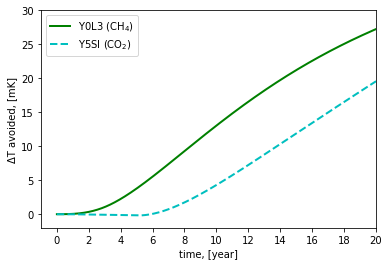

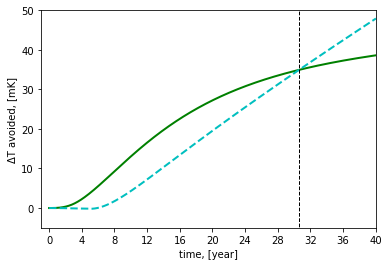

In [9]:
st_year = 0
pl1_ch4 = [0]
pl1_co2 = [0]

for i in pl1_ch4:
    plt.plot(H+st_year, T_av_ch4[i],
             color=ch4_color[i],linestyle='-',
             label=ch4_label[i],linewidth=2)
for i in pl1_ch4:
    plt.plot(H+st_year, T_av_co2[i],
             color=co2_color[i],linestyle='--',
             label=co2_label[i],linewidth=2)
plt.xlabel('time, [year]')
plt.xlim([-1+st_year, 20+st_year])
plt.ylim([-2., 30])
plt.xticks(np.arange(0+st_year, 21+st_year, 2.0))
plt.ylabel('ΔT avoided, [mK]')
plt.legend()
plt.show()

for i in pl1_ch4:
    plt.plot(H+st_year, T_av_ch4[i],
             color=ch4_color[i],linestyle='-',
             label=ch4_label[i],linewidth=2)
for i in pl1_co2:
    plt.plot(H+st_year, T_av_co2[i],
             color=co2_color[i],linestyle=co2_line[i],
             label=co2_label[i],linewidth=2)
# plt.plot([-10, 100],[be_T_30[0],be_T_30[1]],'k--',linewidth=1)
plt.plot([be_t_30,be_t_30],[-10, 1000],'k--',linewidth=1)
plt.xlabel('time, [year]')
plt.xlim([-1+st_year, 40+st_year])
plt.ylim([-5., 50])
plt.xticks(np.arange(0+st_year, 41+st_year, 4.0))
plt.ylabel('ΔT avoided, [mK]')
plt.show()

### 80% Reductions Results

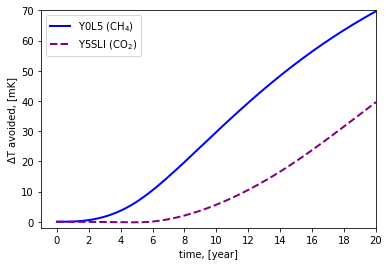

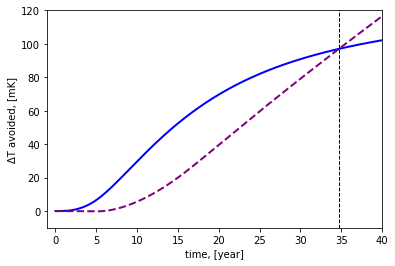

In [10]:
pl2_ch4 = [1]
pl2_co2 = [1]

for i in pl2_ch4:
    plt.plot(H+st_year, T_av_ch4[i],
             color=ch4_color[i],linestyle='-',
             label=ch4_label[i],linewidth=2)
for i in pl2_co2:
    plt.plot(H+st_year, T_av_co2[i],
             color=co2_color[i],linestyle=co2_line[i],
             label=co2_label[i],linewidth=2)
plt.xlabel('time, [year]')
plt.xlim([-1+st_year, 20+st_year])
plt.ylim([-2., 70])
plt.xticks(np.arange(0+st_year, 21+st_year, 2.))
plt.ylabel('ΔT avoided, [mK]')
plt.legend()
plt.show()

for i in pl2_ch4:
    plt.plot(H+st_year, T_av_ch4[i],
             color=ch4_color[i],linestyle='-',
             label=ch4_label[i],linewidth=2)
for i in pl2_co2:
    plt.plot(H+st_year, T_av_co2[i],
             color=co2_color[i],linestyle=co2_line[i],
             label=co2_label[i],linewidth=2)
# plt.plot([-10, 100],[be_T_80[0],be_T_80[1]],'k--',linewidth=1)
plt.plot([be_t_80,be_t_80],[-10, 1000],'k--',linewidth=1)
plt.xlabel('time, [year]')
plt.xlim([-1+st_year, 40+st_year])
plt.ylim([-10., 120])
plt.xticks(np.arange(0+st_year, 41+st_year, 5.))
plt.ylabel('ΔT avoided, [mK]')
plt.show()

### All Results

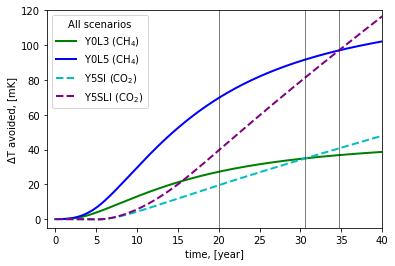

In [11]:
pl2_ch4 = [0,1]
pl2_co2 = [0,1]

for i in pl2_ch4:
    plt.plot(H+st_year, T_av_ch4[i],
             color=ch4_color[i],linestyle='-',
             label=ch4_label[i],linewidth=2)
for i in pl2_co2:
    plt.plot(H+st_year, T_av_co2[i],
             color=co2_color[i],linestyle=co2_line[i],
             label=co2_label[i],linewidth=2)
plt.plot([20,20],[-10, 1000],'k-',linewidth=0.5)
plt.plot([be_t_30,be_t_30],[-10, 1000],'k-',linewidth=0.5)
plt.plot([be_t_80,be_t_80],[-10, 1000],'k-',linewidth=0.5)   
plt.xlabel('time, [year]')
plt.xlim([-1+st_year, 40+st_year])
plt.ylim([-5., 120])
plt.xticks(np.arange(0+st_year, 41+st_year, 5.))
plt.ylabel('ΔT avoided, [mK]')
plt.legend(title='All scenarios')
plt.show()